# Air Quality Foreasting ($CO_2$ emissions) 
## **Business Objective:**
## To forecast $CO_2$ levels for an organization so that the organization can follow government norms with respects to $CO_2$ emission levels.
### Prepare a ppt for each step taken like EDA, Feature Engineering, Model Building,  Model Evaluation and Predicition table, and Deployment. Explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

## Model Building Phase On Sampled data using Interpolation

### Importing the libraries required

In [1]:
# Importing 
# Libraries
import dtale
import time,os 

import warnings
%matplotlib inline
import numpy as np
import pandas as pd

from math import sqrt
import seaborn as sns

import missingno as mn
import plotly.io as pio
sns.set_style('darkgrid')

from pandas import Grouper
from joblib import delayed
import scipy.stats as stat
from joblib import Parallel
import plotly.express as px
from pandas import DataFrame

import statsmodels.api as smf
import pandas_profiling as pp
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from collections import Counter
import plotly.graph_objects as go
import plotly.figure_factory as ff

from pandas.plotting import lag_plot
import statsmodels.formula.api as sm
from multiprocessing import cpu_count
from plotly.offline import plot as off
from plotly.subplots import make_subplots

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import ParameterGrid
from pandas_visual_analysis import VisualAnalysis
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES

from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from dataprep.eda import plot, plot_correlation, plot_missing, create_report

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale, RobustScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV

### Sampling 
### Interpolation
You draw a straight line joining the next and previous points of the missing values in the data.

#### upsampling with respect to month

In [4]:
data=pd.read_excel('C:/Users\Moin Dalvi\Documents\Data Science Material\Projects\Air Quality Forecasting/CO2 dataset.xlsx'\
                   ,index_col='Year',parse_dates=True)

In [5]:
upsampled_month = data.copy()
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                CO2
Year               
1800-01-31  0.00568
1800-02-28      NaN
1800-03-31      NaN
1800-04-30      NaN
1800-05-31      NaN
1800-06-30      NaN
1800-07-31      NaN
1800-08-31      NaN
1800-09-30      NaN
1800-10-31      NaN
1800-11-30      NaN
1800-12-31      NaN
1801-01-31  0.00561


                 CO2
Year                
1800-01-31  0.005680
1800-02-28  0.005674
1800-03-31  0.005668
1800-04-30  0.005662
1800-05-31  0.005657
1800-06-30  0.005651
1800-07-31  0.005645
1800-08-31  0.005639
1800-09-30  0.005633
1800-10-31  0.005628
1800-11-30  0.005622
1800-12-31  0.005616
1801-01-31  0.005610
1801-02-28  0.005605
1801-03-31  0.005600


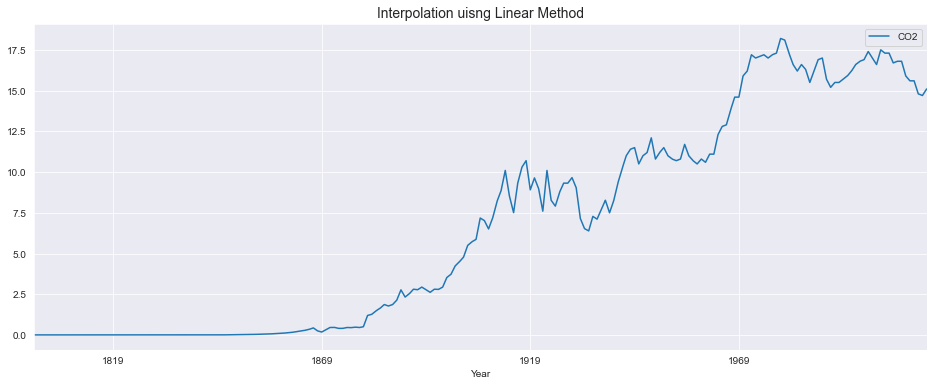

In [7]:
%matplotlib inline
interpolated_month = upsampled_month.interpolate(method='linear') 
## interplation was done for nan values which we get after doing upsampling by month
# ‘linear’: Ignore the index and treat the values as equally spaced. This is the only method supported on MultiIndexes.
print(interpolated_month.head(15))
interpolated_month.plot(figsize=(16,6))
plt.title("Interpolation uisng Linear Method", fontsize =  14)
plt.show()

In [8]:
interpolated_month.to_csv('Interpolated_CO2_dataset.csv')

### Importing Interpolated Dataset from EDA (Sampling Technique Interpolation)
Link for the repository -

In [156]:
data=pd.read_csv('Interpolated_CO2_dataset.csv'\
                , index_col='Year',parse_dates=True)
data.index = pd.DatetimeIndex(data.index.values,freq=data.index.inferred_freq)
#data.set_index('Year', inplace=True)
data.head()

CO2
1800-01-31  0.005680
1800-02-28  0.005674
1800-03-31  0.005668
1800-04-30  0.005662
1800-05-31  0.005657

### Splitting Train and Test Data on Sampling data 

#### Leaving Test Data with 30 Years of Time Series
+ **Training Data** = Fit the model only to training period. 
+ **Testing Data** = Assess the model performance on Testing. 
+ **Deploy model by training on whole dataset. No random partition That’s because the order sequence of the time series should be intact in order to use it for forecasting.**

In [157]:
size = -241
train_data = data[:size]
test_data = data[size:]

In [158]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1800-01-31 00:00:00 1993-12-31 00:00:00 
 Test: 1994-01-31 00:00:00 2014-01-31 00:00:00


### We are going to forecast for the last 20 years. that is from 1994 to 2014.

##### Last 241 records contain data from 1994 to 2014 data.

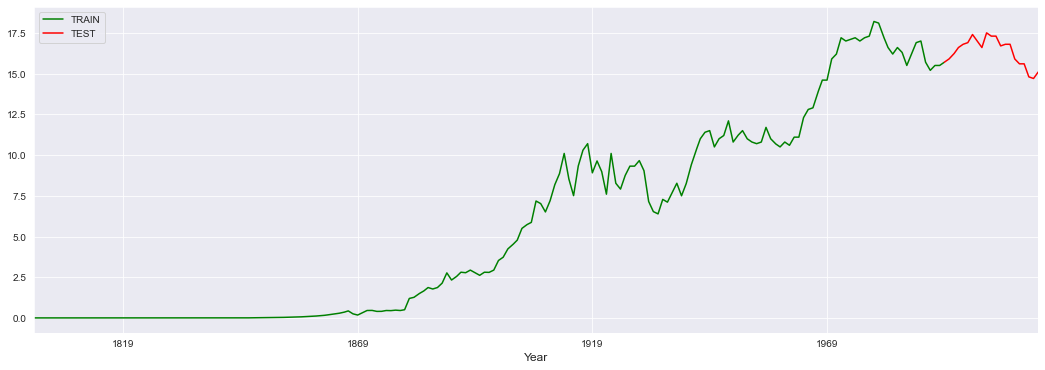

In [22]:
train_data.CO2.plot(legend=True,label='TRAIN',color='green')
test_data.CO2.plot(legend=True,label='TEST', figsize=(18,6),color='red')
plt.xlabel('Year', fontsize= 12)
plt.legend()
plt.show()

### Evaluation Metric MAPE

In [101]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

## Model Building

___
## Exponential Methods
### Simple Exponential Method

#### Using Forecast Attribute

In [13]:
ses_model = SimpleExpSmoothing(train_data['CO2']).fit(optimized=True)
test_pred_ses = ses_model.forecast(241)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.CO2))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.CO2)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 5.60011181261523 
 Train Root Mean Squared Error = 0.046873369548940766 
 Test Root Mean Squared Error = 1.0658218691171106


In [153]:
test_pred_ses

1994-01-31    15.683333
1994-02-28    15.683333
1994-03-31    15.683333
1994-04-30    15.683333
1994-05-31    15.683333
                ...    
2013-09-30    15.683333
2013-10-31    15.683333
2013-11-30    15.683333
2013-12-31    15.683333
2014-01-31    15.683333
Freq: M, Length: 241, dtype: float64

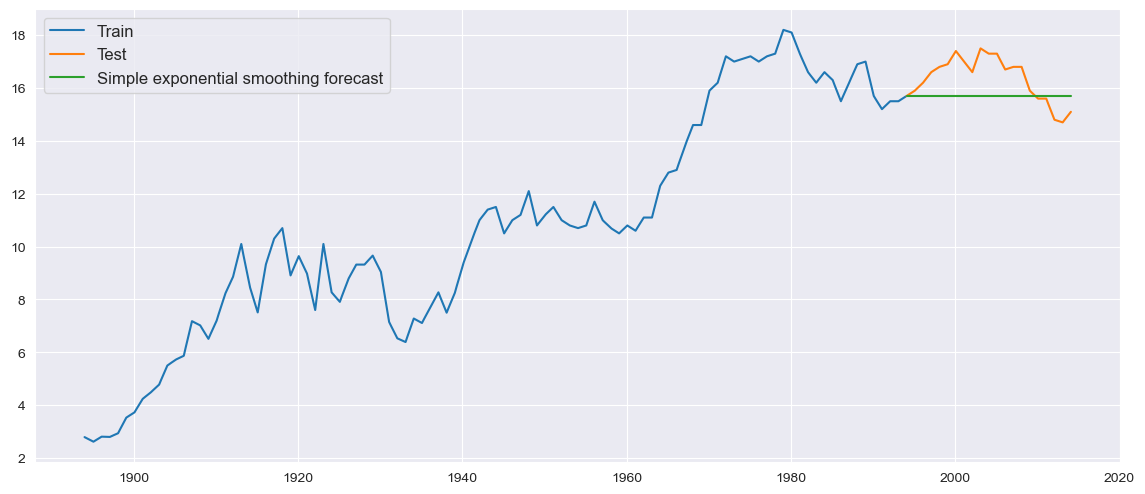

In [160]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data[-1201:], label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. **This method doesn't captures seasonality.**

---
### Holt method (Double Exponential) 

##### Captures both Level and Trend .

In [14]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(241)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.CO2))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.CO2)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 9.278108141589744 
 Train Root Mean Squared Error = 0.019339803000748758 
 Test Root Mean Squared Error = 2.157961018743031


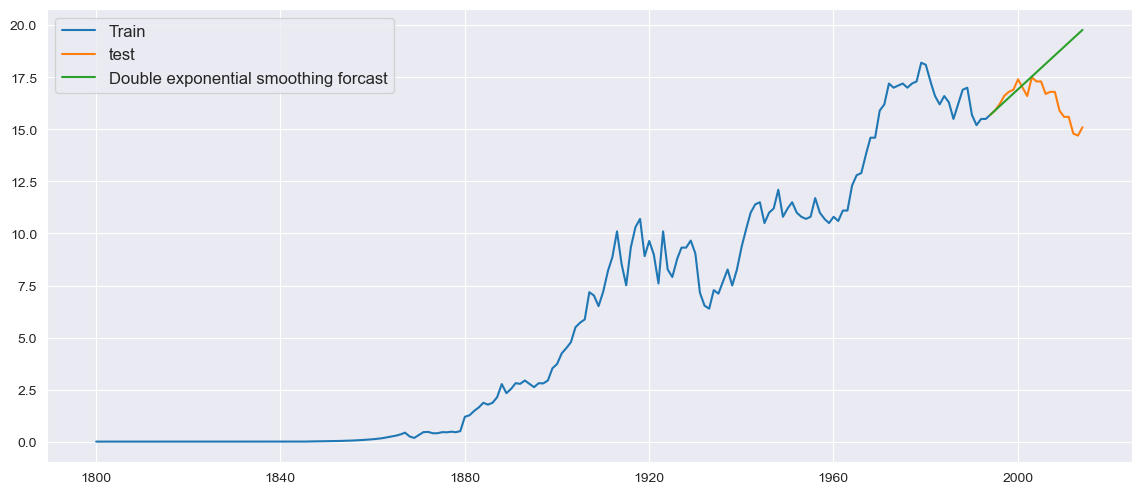

In [143]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. We can see that we are able to capture the trend of the data.
2. We were not able to capture the seasonality.

### Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

##### Captures Level, Trend and Seasonality.

In [15]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(241)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.CO2))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.CO2)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 9.273948858085678 
 Train Root Mean Squared Error = 0.019343116578147024 
 Test Root Mean Squared Error = 2.1570607634618737


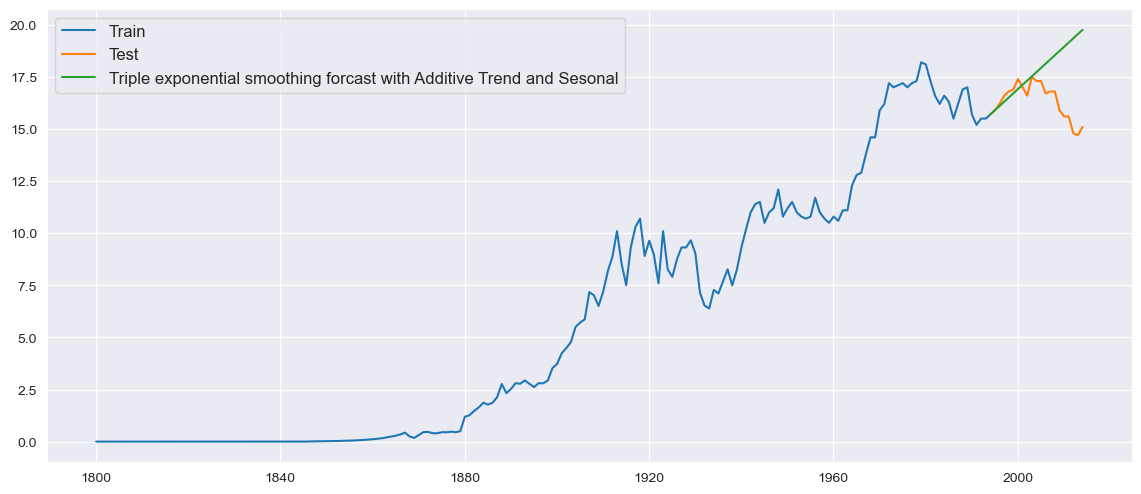

In [145]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. It captures the trend, but which we can see that the forecasted values are higher level than the test level.
2. It doesn't captures the seasonality.

### Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [16]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(241)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.CO2))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.CO2)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 8.286449408132427 
 Train Root Mean Squared Error = 0.019321264088668775 
 Test Root Mean Squared Error = 1.9369844493177666


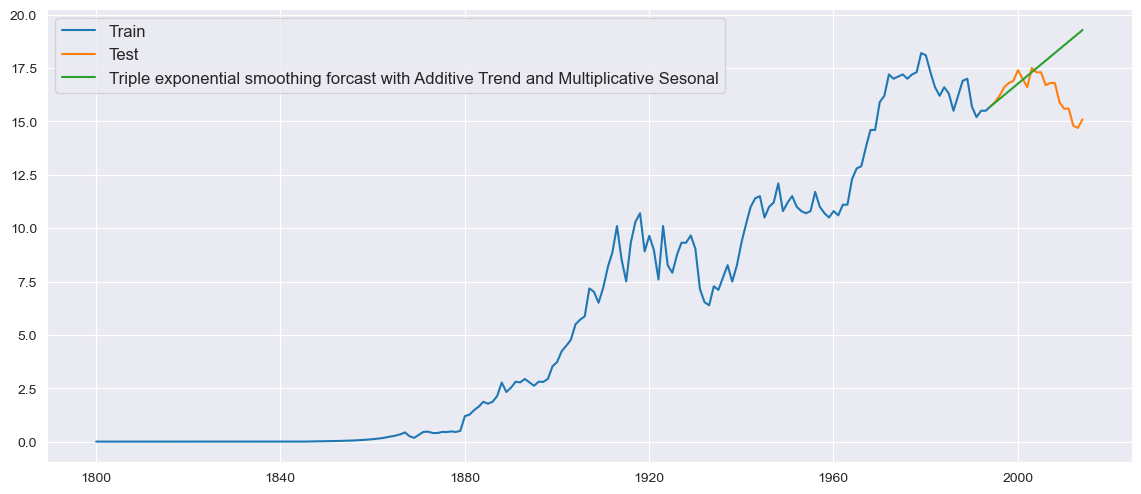

In [147]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. We can see that the errors have not reduced, we are not able to capture the seasonality.

### Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [17]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(241)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.CO2))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.CO2)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 21.538050344437522 
 Train Root Mean Squared Error = 0.2299631811310163 
 Test Root Mean Squared Error = 4.592563312352205


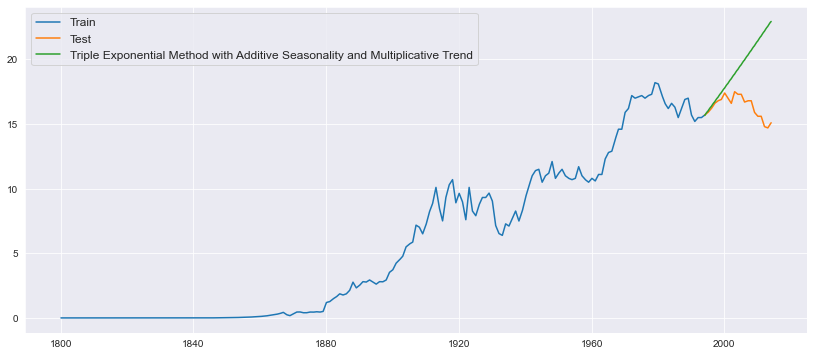

In [149]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best', fontsize=12)
plt.show()

### Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [18]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(241)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.CO2))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.CO2)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 8.599648537004366 
 Train Root Mean Squared Error = 0.019359490985997225 
 Test Root Mean Squared Error = 2.0114097189905187


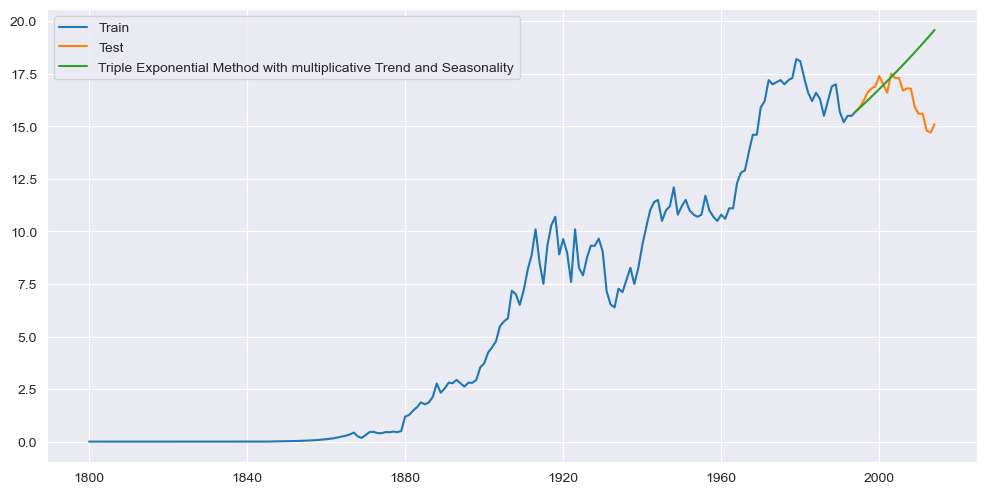

In [151]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

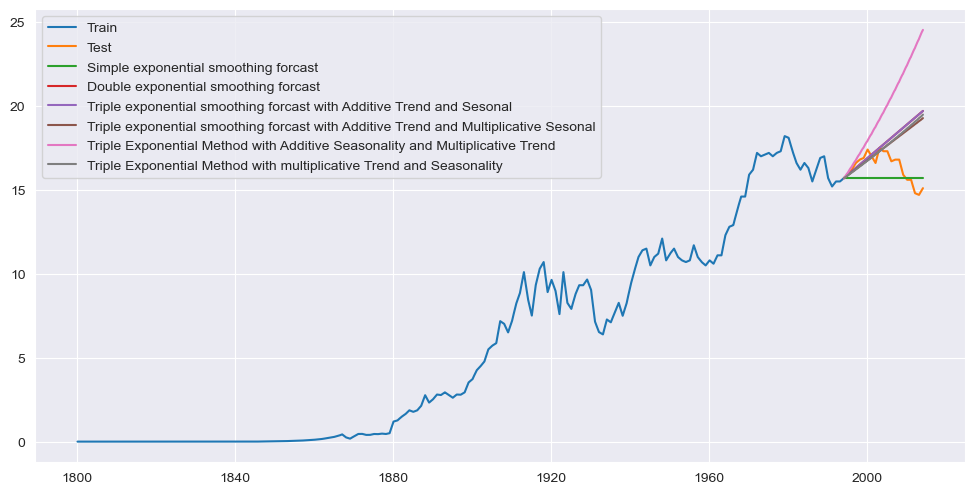

In [19]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

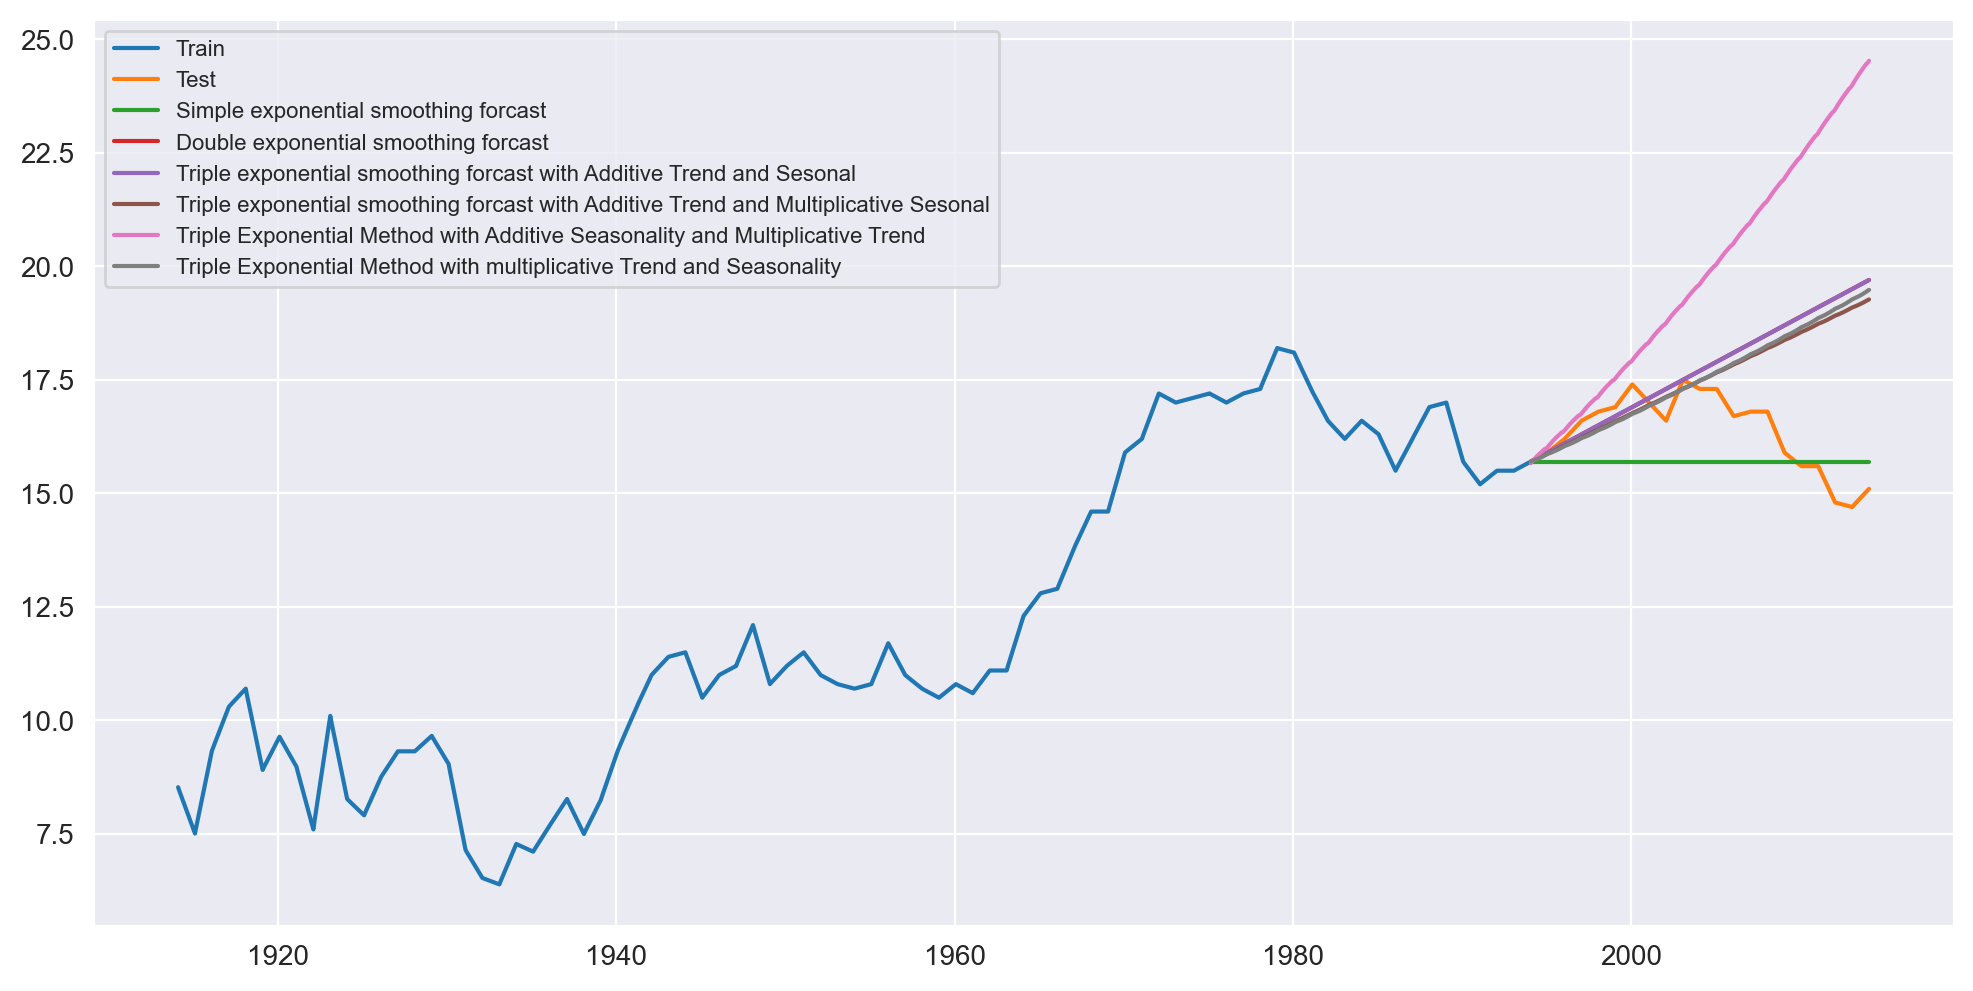

In [21]:
plt.figure(figsize=(12,6), dpi=200)
plt.plot(train_data.iloc[-960:], label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best', fontsize=8)
plt.show()

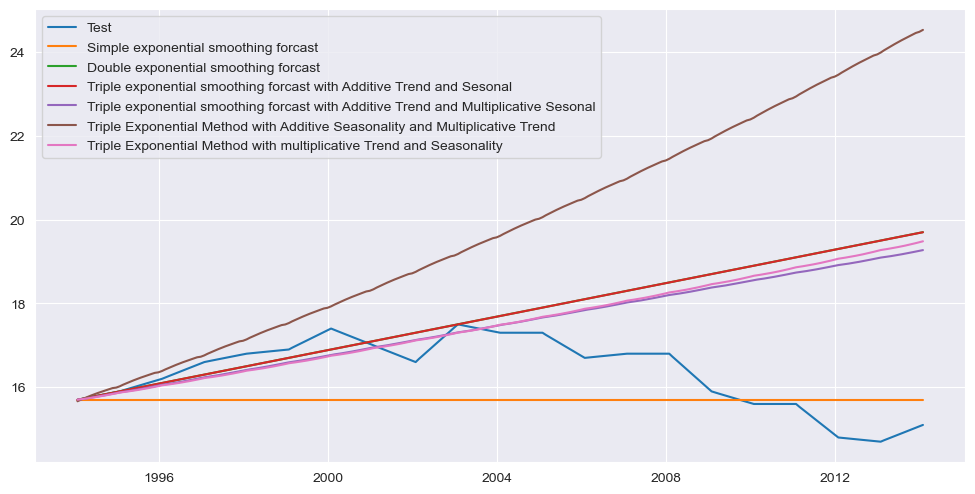

In [75]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

In [22]:
#Comparing the results 

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0         Simple_Exp    0.046873      5.600112          1.065822
1  Triple_Exp_mul_ad    0.019321      8.286449          1.936984
2     Triple_Exp_mul    0.019359      8.599649          2.011410
3      Triple_Exp_ad    0.019343      9.273949          2.157061
4         Double_Exp    0.019340      9.278108          2.157961
5  Triple_Exp_ad_mul    0.229963     21.538050          4.592563

### Visualizing Models Performance

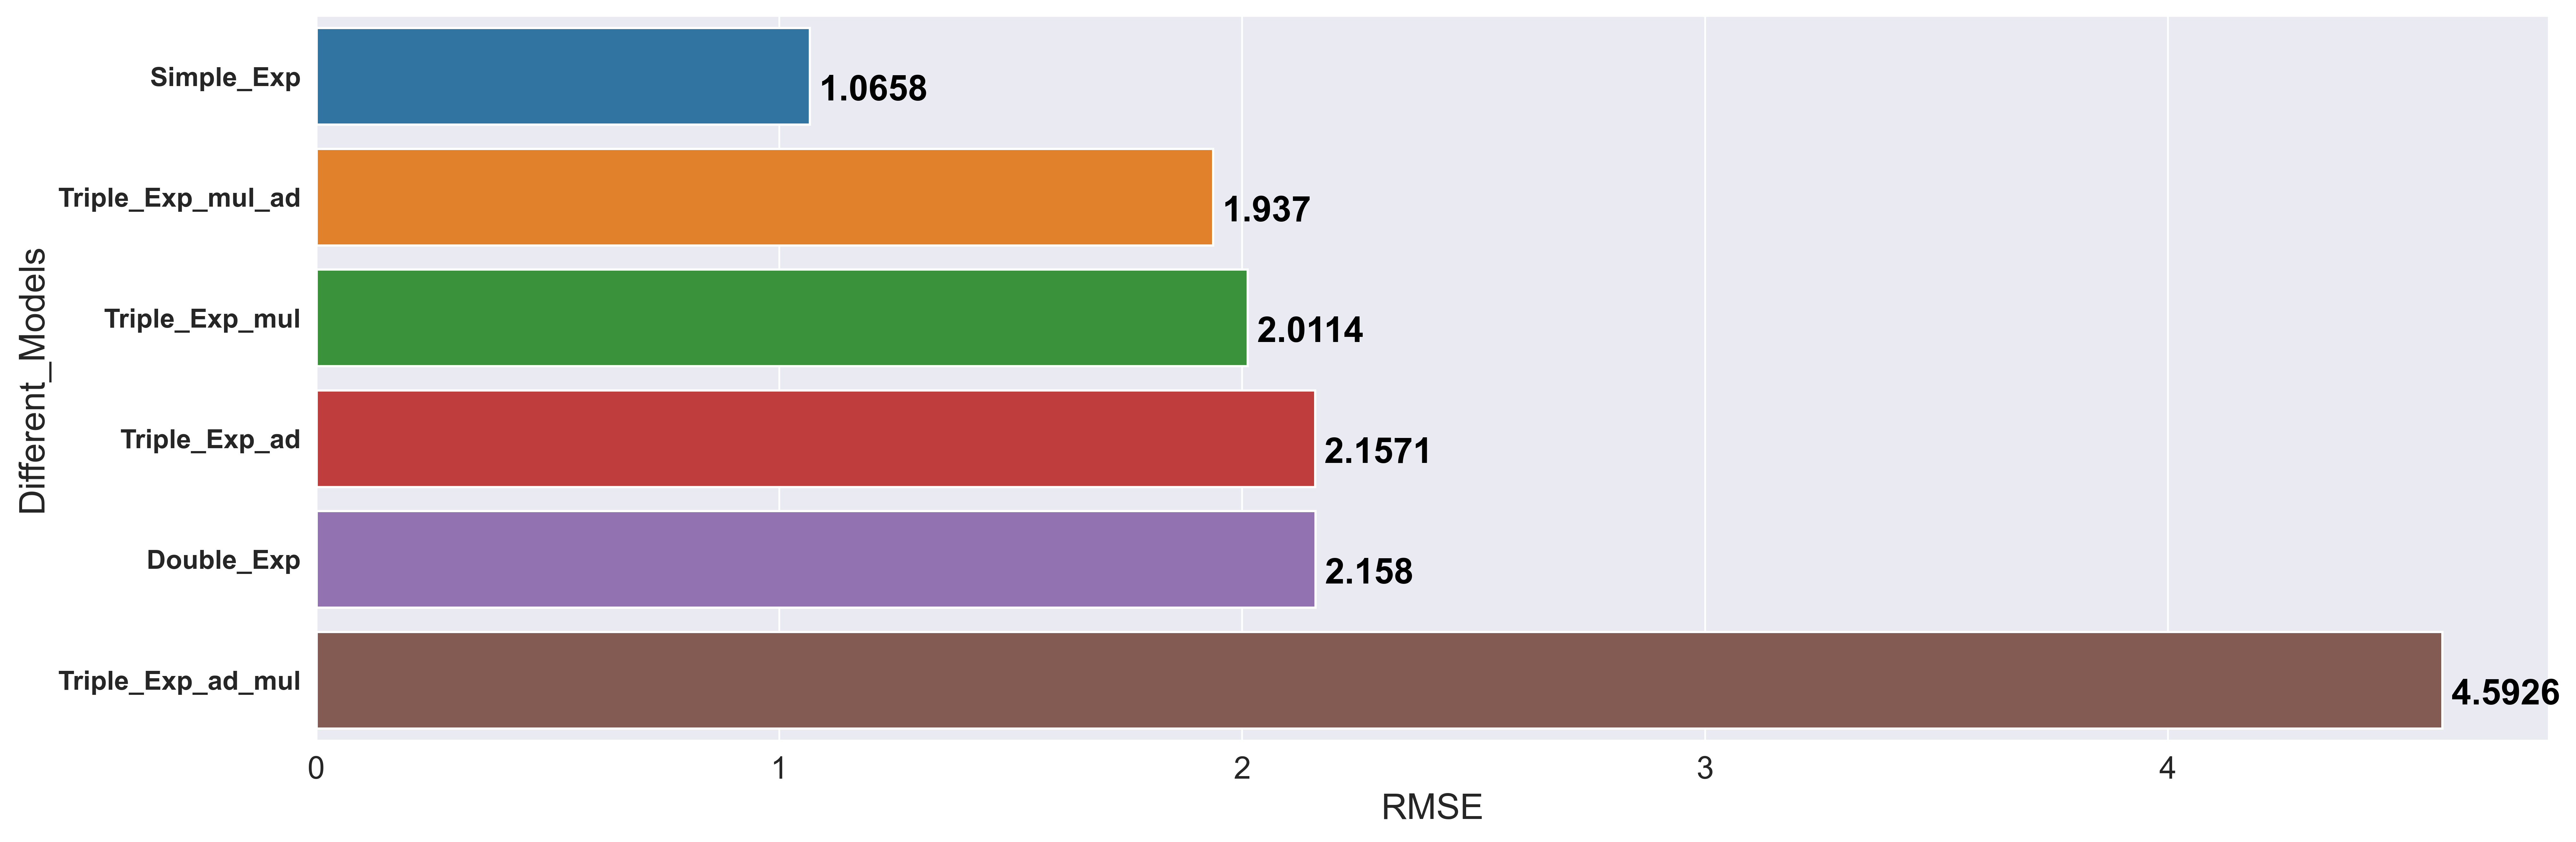

In [17]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,2)):
    axe.text(v + 0.02, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

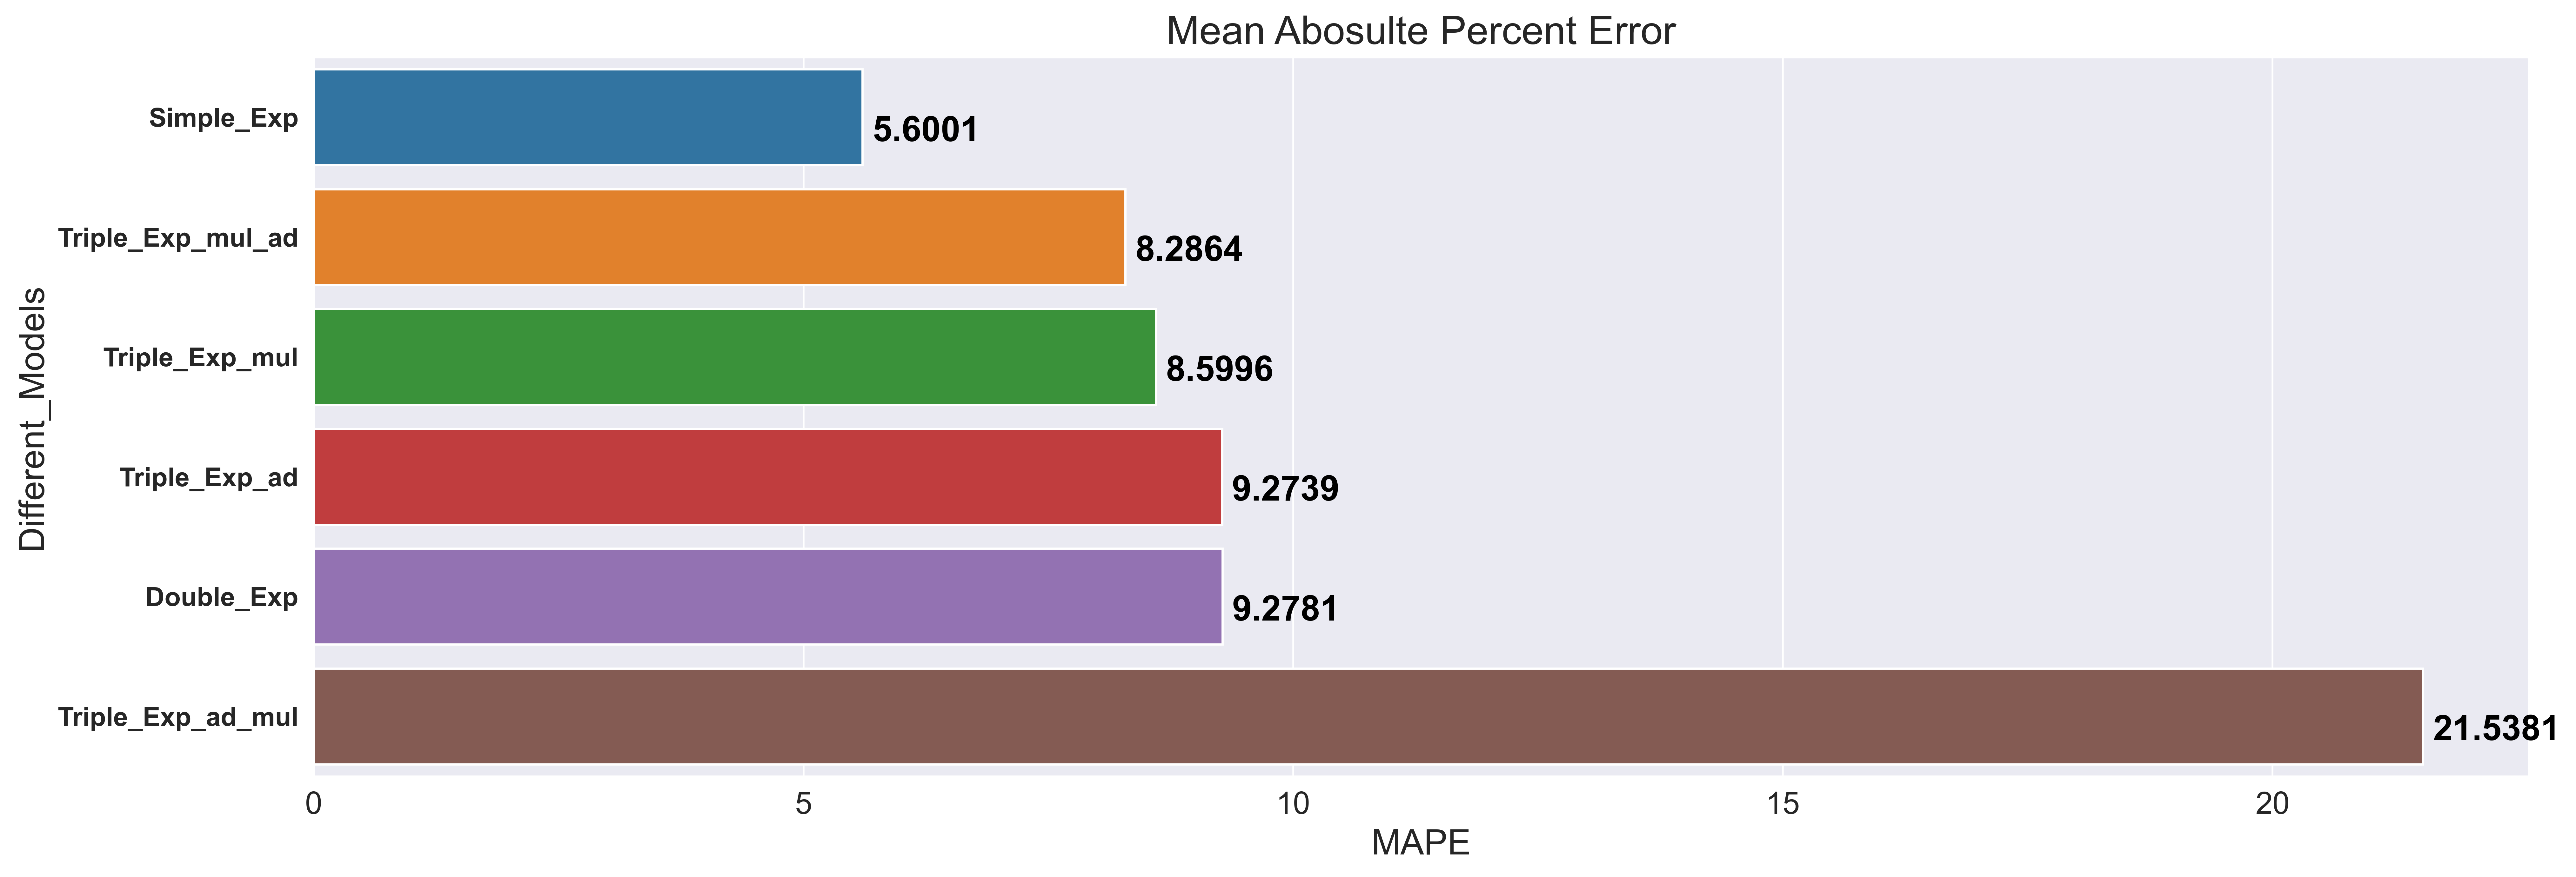

In [18]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_MAPE(%)', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('MAPE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.title("Mean Abosulte Percent Error", fontsize = 18)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation['Test_MAPE(%)'].values,2)):
    axe.text(v + 0.1, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

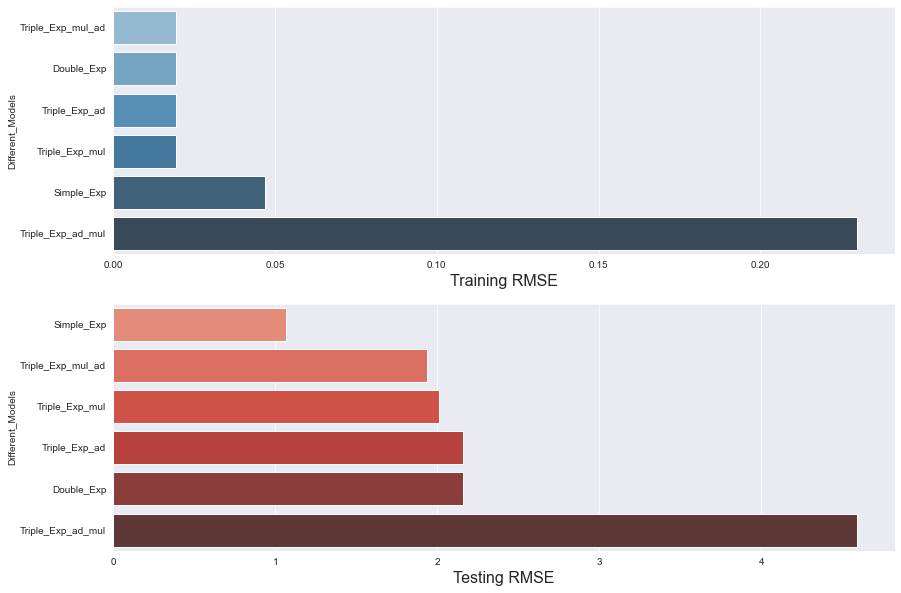

In [19]:
f, axes = plt.subplots(2,1, figsize=(14,10))
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=True)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=True)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

# Autoregressive Integrated Moving Averages (ARIMA)

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

### Assumptions of ARIMA model
1. **Data should be stationary** – by stationary it means that the properties of the series doesn’t depend on the time when it is captured. A white noise series and series with cyclic behavior can also be considered as stationary series.
2. **Data should be univariate** – ARIMA works on a single variable. Auto-regression is all about regression with the past values.

#### Stationary vs Non-stationary Time Series

#### Augmented Dicky Fuller Test
Null Hypothesis (H0): The series is not stationary

p-val > 0.05

Alternate Hypothesis (H1): The series is stationary

p-val <= 0.05

### Test of Stationarity

##### As we have yearly data the window size for moving average is equal to 12

In [14]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.figure(figsize=(16,6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['CO2'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(np.round(dfoutput,3))
    
    result = adfuller(timeseries.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")

### Converting Non-Stationary Time Series into Stationary

#### Differencing
In this method, we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean. Mathematically, differencing can be written as:

yt‘ = yt – y(t-1)

where yt is the value at a time t

Applying differencing on our series and plotting the results:

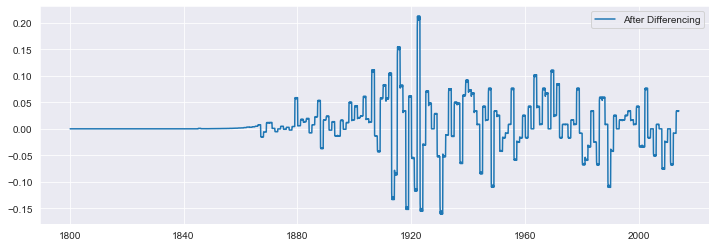

In [8]:
differencing = data - data.shift(1)
differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')
plt.show()

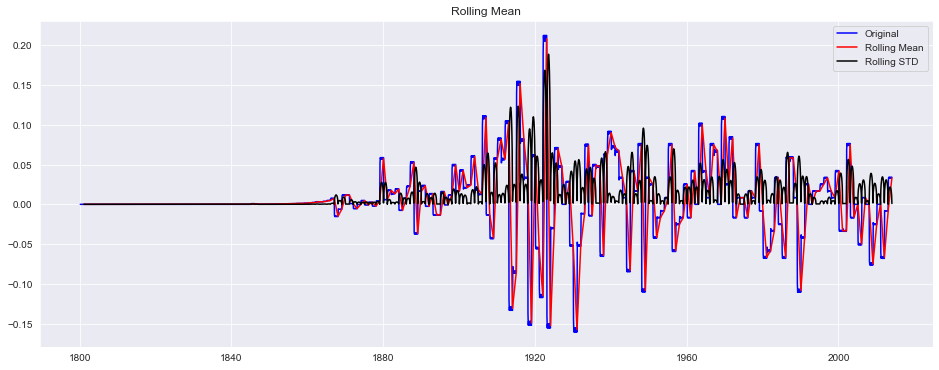

Results of Dickey Fuller Test:
Test Statistic                   -7.703
p-value                           0.000
#Lags Used                       27.000
Number of Observations Used    2540.000
Critical Value (1%)              -3.433
Critical Value (5%)              -2.863
Critical Value (10%)             -2.567
dtype: float64
Reject the null hypothesis
Data is stationary


In [191]:
test_stationarity(differencing)

#### Box Cox Transformation

CO2
1800-01-31 -5.170804
1800-02-28 -5.171750
1800-03-31 -5.172798
1800-04-30 -5.173814
1800-05-31 -5.174864

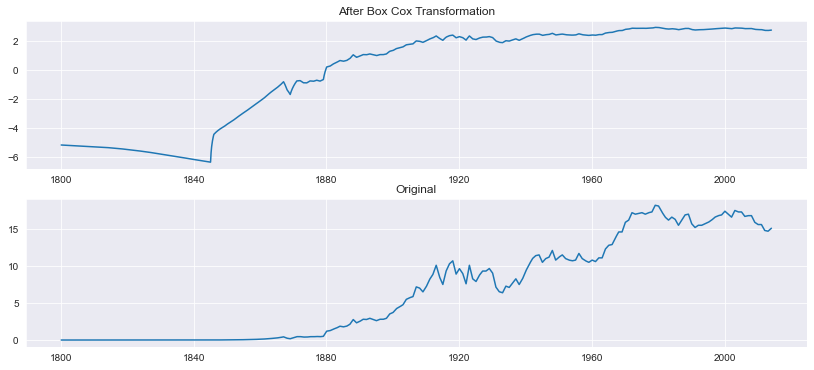

In [192]:
data_boxcox = pd.DataFrame()
data_boxcox['CO2'] = pd.Series(boxcox(data['CO2'], lmbda=0), data.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(data, label='original')
axis[1].set_title('Original')
plt.show()

#### Observation
1. We can see the variance became almost different after the transformation. Both in the earlier and later years the variance has significantly changed.
2. But we can see that still the series has an upward trend. So, the mean is not constant yet. Hence, we need to do `Differencing` for making the mean constant.

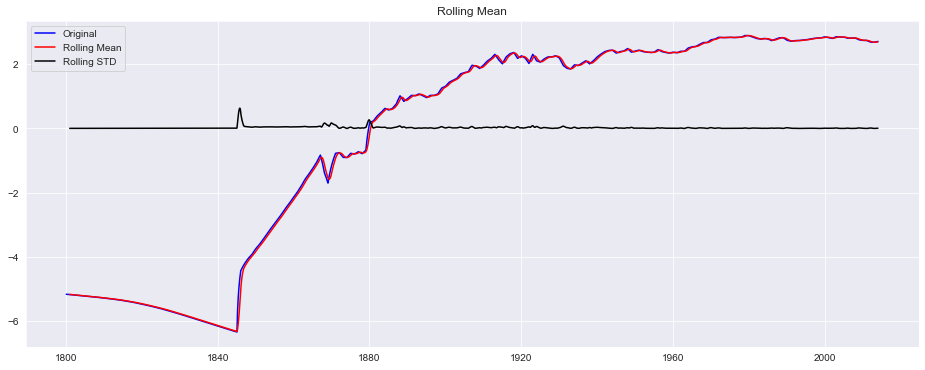

Results of Dickey Fuller Test:
Test Statistic                   -1.370
p-value                           0.597
#Lags Used                       13.000
Number of Observations Used    2555.000
Critical Value (1%)              -3.433
Critical Value (5%)              -2.863
Critical Value (10%)             -2.567
dtype: float64
Fail to reject the null hypothesis


In [193]:
test_stationarity(data_boxcox)

#### Differencing of the Box-Cox Transformation
Differencing is performed by subtracting the previous observation from the current observation.

Differencing removes trend and seasonality in a Time series. When an entire cycle is used for differencing the other cycle, then the seasonality is removed.

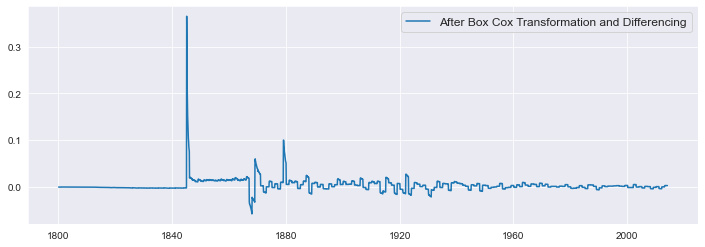

In [194]:
# data_boxcox - data_boxcox.shift() :- Performs difference between the previous and current observations.
#data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation. 
2. It is a horizontal trend.
3. The mean became constant. The mean is zero.
4. Also, the variance is almost constant.

Lets test the Stationarity again.

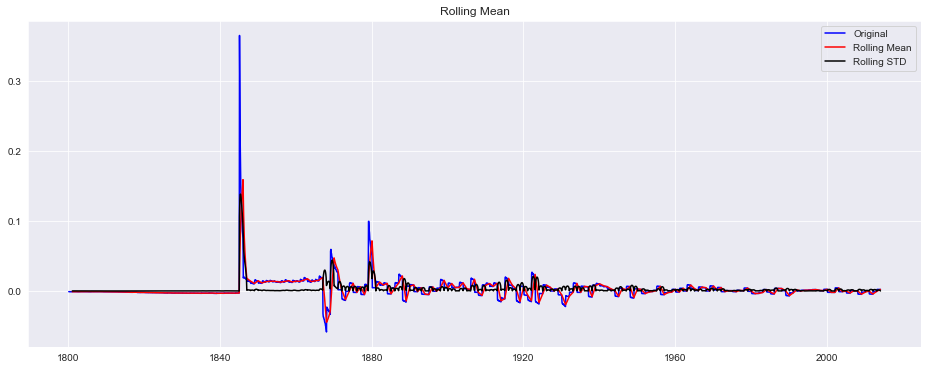

Results of Dickey Fuller Test:
Test Statistic                  -10.146
p-value                           0.000
#Lags Used                       12.000
Number of Observations Used    2555.000
Critical Value (1%)              -3.433
Critical Value (5%)              -2.863
Critical Value (10%)             -2.567
dtype: float64
Reject the null hypothesis
Data is stationary


In [195]:
#check this log transfered data with function
test_stationarity(data_boxcox_diff)

#### ^Observation: Finally our data is stationary and it does not have any trend and seasonality. The data does not depend on the time when it is captured.

##### Finally, Our Time Series is now stationary for AR Forecasting

## ARIMA Hyperparameter Tuning

***order(p,d,q)***

p = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series.

d = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary.


q = This variable denotes the lag of the error component, where error component is a part of the time series not explained by trend or seasonality.

In [97]:
import itertools

In [98]:
p = range(0,8)
q = range(0,8)
d = range(0,3)

In [99]:
pqd_combination = list(itertools.product(p,d,q))

In [100]:
len(pqd_combination)

192

In [101]:
rmse = []
order = []

In [105]:
for pdq in pqd_combination:
    try:
        model = ARIMA(train_data, order=pdq).fit()
        pred = model.predict(start=len(train_data),end=(len(data)-1))
        error = np.sqrt(mean_squared_error(test_data,pred))
        order.append(pdq)
        rmse.append(error)
    except:
        continue

In [106]:
results = pd.DataFrame(index=order,data=rmse,columns=['RMSE'])
results.sort_values('RMSE')

RMSE
(6, 2, 5)   0.760790
(4, 0, 5)   0.760893
(2, 0, 7)   0.764561
(4, 0, 7)   0.766415
(7, 0, 3)   0.770760
...              ...
(0, 0, 2)  11.074777
(6, 0, 2)  11.078823
(0, 0, 1)  11.087304
(0, 0, 0)  11.100848
(3, 0, 0)  12.801259

[191 rows x 1 columns]

In [15]:
size = -241
train_data = data[:size]
test_data = data[size:]

In [28]:
model = ARIMA(train_data, order=(6, 2, 5))
model_fit = model.fit()
y_hat_ar = data.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data.index.min(), data.index.max())

In [19]:
%matplotlib inline

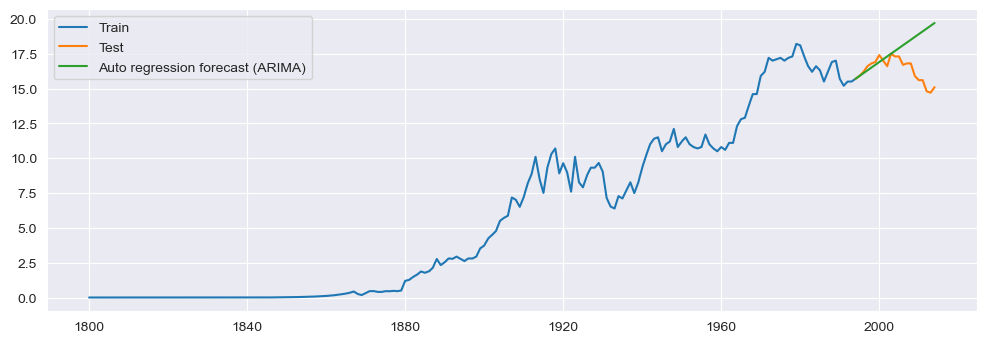

In [29]:
plt.figure(figsize=(12,4), dpi =100)
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (ARIMA)')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that we have done moderately well.
2. No Seasonality captured. Only Trend has been captured

### Model Evaluation

#### RMSE (Root Mean Squared Error)

In [36]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

2.16

#### MAPE (Mean Absolute Percent Error)

In [37]:
mape_arima = round(np.mean(np.abs((test_data.CO2 - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.CO2)*100),2)
mape_arima

9.28

#### Observation
1. We can see that AR model has done reasonably good job but not better than Holt's method.
2. We souldn't compare it with Holt's method. Because Holt's method captures seasonality

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [23]:
model_residual = model_fit.resid
model_residual.mean()

1.10126028896544e-05

#### Residuals must be stationary

In [24]:
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [121]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

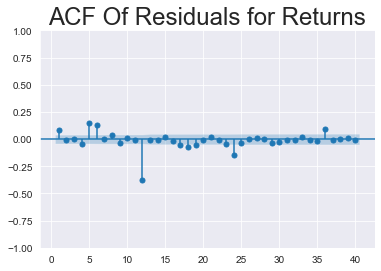

In [25]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

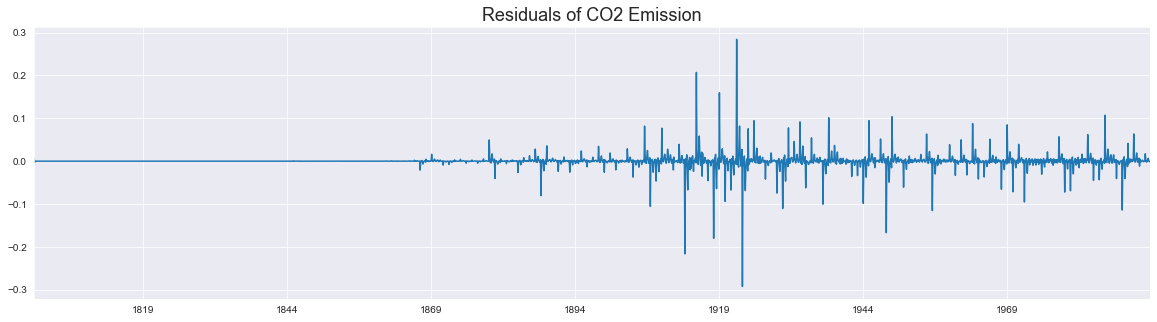

In [26]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of CO2 Emission", size=18)
plt.show()

### Seasonal Auto Regressive Integrated Moving Average (SARIMA)
ARIMA with Seasonal component added.

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# We are only passing the Box Cox because the ARIMAX will perform the differencing internally
# seasonal_order P=1, Q=1, D=1 and m=12
# m=12 . Because the seasonality is monthly.

In [31]:
model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data.copy()

#### Inverse Transformation of the Differencing Box-Cox Transformation
Note that ARIMAM automatically takes care of the reversing of `Differencing` (takes care the `Integration` part automatically). So, we don't need to perform the cumsum here. We only have to do the reverse of the log boc cox transformation.

In ARIMA, we had to perform the cumsum manually.

In [32]:
y_hat_sarima['sarima_forecast'] = model_fit.predict(data.index.min(), data.index.max())

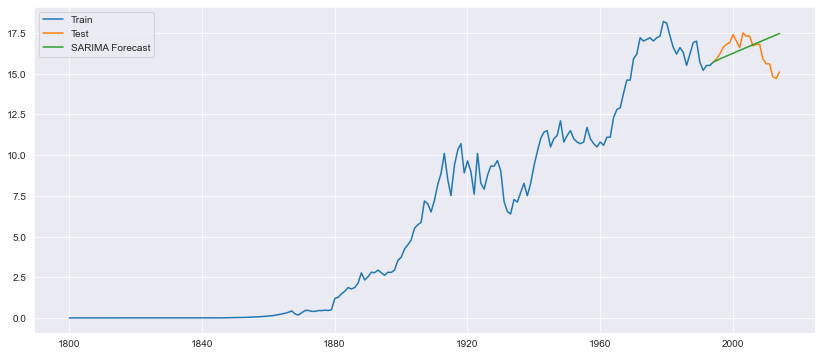

In [33]:
plt.figure(figsize=(14,6))
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

##### We can see that we are able to capture the trend and seasonality both.

### Model Evaluation

#### RMSE (Root Mean Squared Error)

In [38]:
rmse_SARIMA = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_SARIMA

1.16

#### MAPE (Mean Absolute Percent Error)

In [39]:
mape_sarima = round(np.mean(np.abs((test_data.CO2 - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.CO2)*100),2)
mape_sarima

5.55

#### Observation:
1. SARIMA method has done reasonably well as it captures seasonality.
2. The performance is comparable with the other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality. |

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [38]:
model_residual = model_fit.resid
model_residual.mean()

0.00023872546767587927

#### Residuals must be stationary

In [39]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

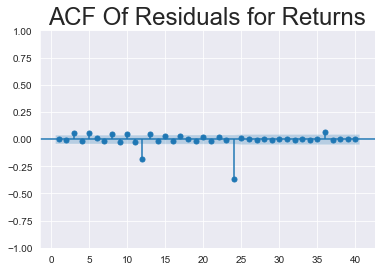

In [40]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

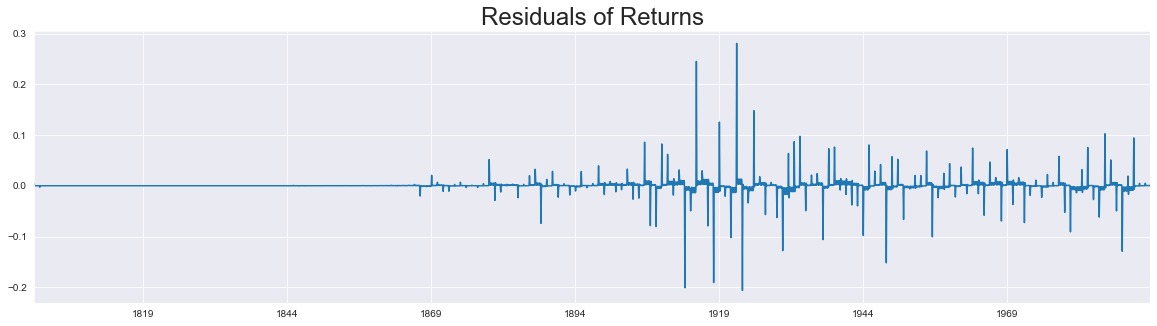

In [41]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

#### Creating model with differente Transformation Technique

In [40]:
#Compareing the results 

Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_additive","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_multiplicative","ARIMA","SARIMA"]),\
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_sarima]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_ARIMA,rmse_SARIMA])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

Models    MAPE(%)  RMSE_Values
0         Simple_Exponential   5.600112     1.065822
1                     SARIMA   5.550000     1.160000
2          Triple_Exp_mul_ad   8.286449     1.936984
3  Triple_Exp_multiplicative   8.599649     2.011410
4        Triple_Exp_additive   9.273949     2.157061
5         Double_Exponential   9.278108     2.157961
6                      ARIMA   9.280000     2.160000
7          Triple_Exp_ad_mul  21.538050     4.592563

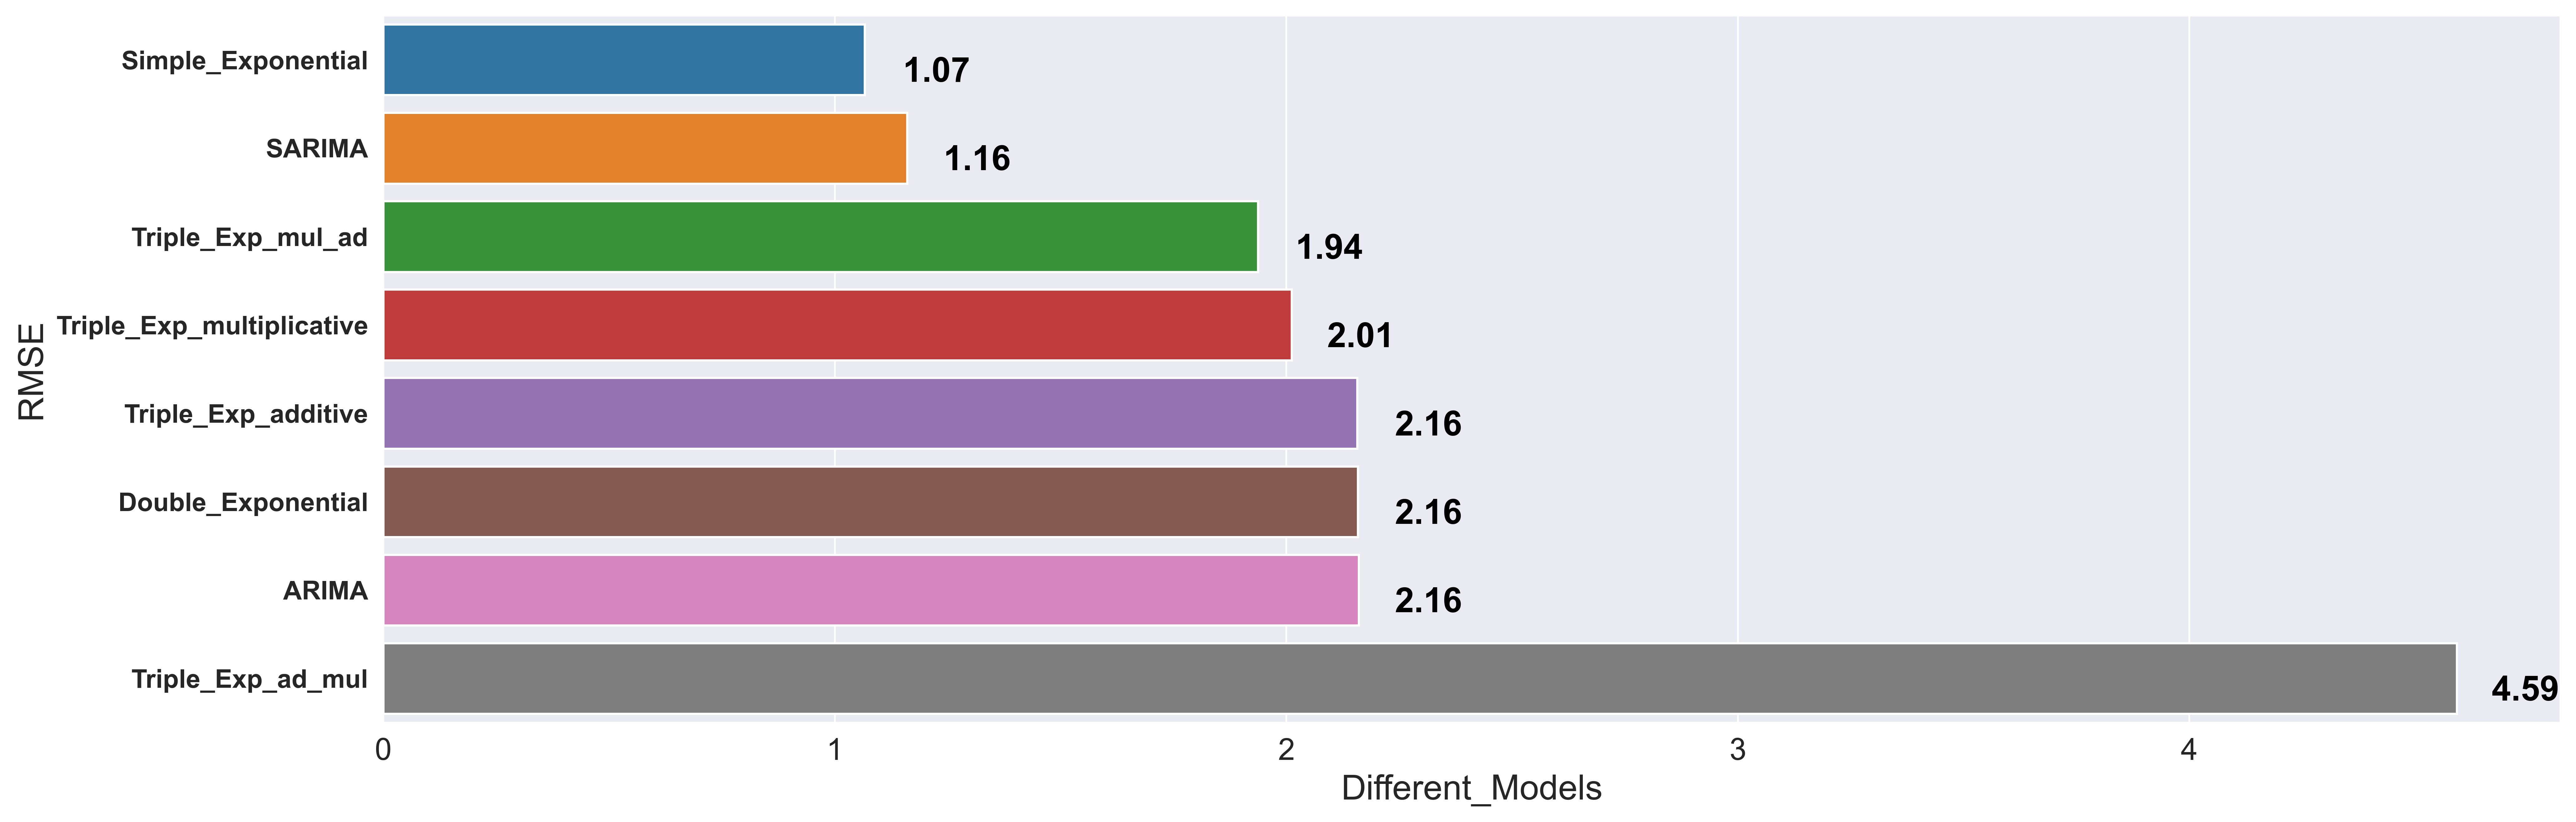

In [41]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,2)):
    axe.text(v + 0.08, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

In [45]:
y_hat_sarima

CO2  sarima_forecast
1800-01-31   0.005680         0.000000
1800-02-28   0.005674         0.005680
1800-03-31   0.005668         0.005674
1800-04-30   0.005662         0.005668
1800-05-31   0.005657         0.005663
...               ...              ...
2013-09-30  14.966667        17.434335
2013-10-31  15.000000        17.441514
2013-11-30  15.033333        17.448688
2013-12-31  15.066667        17.455858
2014-01-31  15.100000        17.463021

[2569 rows x 2 columns]

#### Observation:
+ **The Sarima Model did very well as compared to other Models but Simple Exponential Smoothing Method did slightly better** 
+ **Note:Sarima with Hyperparameter tuning may get better results**
+ **Even in methods such as Triple Exponential Smoothing (Holts-Winters Method) taking Seasonality and Trend as Multiplicative did not gave the best restult in this case**

### Data Pre-processing for Model Driven Techniques

#### Creating Dummy Variables of the Categorical Feature Month of Date Time feature 

In [62]:
co_two_emission = pd.read_csv('CO2_dataset_FE.csv')
co_two_emission.drop('Unnamed: 0', axis=1 , inplace =True)
co_two_emission

Year        CO2     t  t_squared month  year  Jan  Feb  Mar  Apr  \
0     1800-01-31   0.005680     1          1   Jan  1800    1    0    0    0   
1     1800-02-28   0.005675     2          4   Feb  1800    0    1    0    0   
2     1800-03-31   0.005669     3          9   Mar  1800    0    0    1    0   
3     1800-04-30   0.005663     4         16   Apr  1800    0    0    0    1   
4     1800-05-31   0.005657     5         25   May  1800    0    0    0    0   
...          ...        ...   ...        ...   ...   ...  ...  ...  ...  ...   
2564  2013-09-30  14.965205  2565    6579225   Sep  2013    0    0    0    0   
2565  2013-10-31  14.999178  2566    6584356   Oct  2013    0    0    0    0   
2566  2013-11-30  15.032055  2567    6589489   Nov  2013    0    0    0    0   
2567  2013-12-31  15.066027  2568    6594624   Dec  2013    0    0    0    0   
2568  2014-01-31  15.100000  2569    6599761   Jan  2014    1    0    0    0   

      May  Jun  Jul  Aug  Sep  Oct  Nov  Dec   log_CO2  
0       0    0    0    0    0    0    0    0 -5.170804  
1       0    0    0    0    0    0    0    0 -5.171750  
2       0    0    0    0    0    0    0    0 -5.172798  
3       0    0    0    0    0    0    0    0 -5.173814  
4       1    0    0    0    0    0    0    0 -5.174864  
...   ...  ...  ...  ...  ...  ...  ...  ...       ...  
2564    0    0    0    0    1    0    0    0  2.705728  
2565    0    0    0    0    0    1    0    0  2.707995  
2566    0    0    0    0    0    0    1    0  2.710185  
2567    0    0    0    0    0    0    0    1  2.712442  
2568    0    0    0    0    0    0    0    0  2.714695  

[2569 rows x 19 columns]

#### Splitting data into Train and Test 

In [120]:
size

-241

In [115]:
train_data = co_two_emission.iloc[:size]
test_data = co_two_emission.iloc[size:]

In [116]:
train_data

Year        CO2     t  t_squared month  year  Jan  Feb  Mar  Apr  \
0     1800-01-31   0.005680     1          1   Jan  1800    1    0    0    0   
1     1800-02-28   0.005675     2          4   Feb  1800    0    1    0    0   
2     1800-03-31   0.005669     3          9   Mar  1800    0    0    1    0   
3     1800-04-30   0.005663     4         16   Apr  1800    0    0    0    1   
4     1800-05-31   0.005657     5         25   May  1800    0    0    0    0   
...          ...        ...   ...        ...   ...   ...  ...  ...  ...  ...   
2323  1993-08-31  15.616164  2324    5400976   Aug  1993    0    0    0    0   
2324  1993-09-30  15.632603  2325    5405625   Sep  1993    0    0    0    0   
2325  1993-10-31  15.649589  2326    5410276   Oct  1993    0    0    0    0   
2326  1993-11-30  15.666027  2327    5414929   Nov  1993    0    0    0    0   
2327  1993-12-31  15.683014  2328    5419584   Dec  1993    0    0    0    0   

      May  Jun  Jul  Aug  Sep  Oct  Nov  Dec   log_CO2  
0       0    0    0    0    0    0    0    0 -5.170804  
1       0    0    0    0    0    0    0    0 -5.171750  
2       0    0    0    0    0    0    0    0 -5.172798  
3       0    0    0    0    0    0    0    0 -5.173814  
4       1    0    0    0    0    0    0    0 -5.174864  
...   ...  ...  ...  ...  ...  ...  ...  ...       ...  
2323    0    0    0    1    0    0    0    0  2.748307  
2324    0    0    0    0    1    0    0    0  2.749359  
2325    0    0    0    0    0    1    0    0  2.750445  
2326    0    0    0    0    0    0    1    0  2.751495  
2327    0    0    0    0    0    0    0    1  2.752578  

[2328 rows x 19 columns]

In [117]:
test_data

Year        CO2     t  t_squared month  year  Jan  Feb  Mar  Apr  \
2328  1994-01-31  15.700000  2329    5424241   Jan  1994    1    0    0    0   
2329  1994-02-28  15.715342  2330    5428900   Feb  1994    0    1    0    0   
2330  1994-03-31  15.732329  2331    5433561   Mar  1994    0    0    1    0   
2331  1994-04-30  15.748767  2332    5438224   Apr  1994    0    0    0    1   
2332  1994-05-31  15.765753  2333    5442889   May  1994    0    0    0    0   
...          ...        ...   ...        ...   ...   ...  ...  ...  ...  ...   
2564  2013-09-30  14.965205  2565    6579225   Sep  2013    0    0    0    0   
2565  2013-10-31  14.999178  2566    6584356   Oct  2013    0    0    0    0   
2566  2013-11-30  15.032055  2567    6589489   Nov  2013    0    0    0    0   
2567  2013-12-31  15.066027  2568    6594624   Dec  2013    0    0    0    0   
2568  2014-01-31  15.100000  2569    6599761   Jan  2014    1    0    0    0   

      May  Jun  Jul  Aug  Sep  Oct  Nov  Dec   log_CO2  
2328    0    0    0    0    0    0    0    0  2.753661  
2329    0    0    0    0    0    0    0    0  2.754637  
2330    0    0    0    0    0    0    0    0  2.755718  
2331    0    0    0    0    0    0    0    0  2.756762  
2332    1    0    0    0    0    0    0    0  2.757840  
...   ...  ...  ...  ...  ...  ...  ...  ...       ...  
2564    0    0    0    0    1    0    0    0  2.705728  
2565    0    0    0    0    0    1    0    0  2.707995  
2566    0    0    0    0    0    0    1    0  2.710185  
2567    0    0    0    0    0    0    0    1  2.712442  
2568    0    0    0    0    0    0    0    0  2.714695  

[241 rows x 19 columns]

### Building Ordinary Square Model (Linear Model)

In [125]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('CO2~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(pred_linear))**2))
rmse_linear

1.211642102496849

In [127]:
mape_linear= MAPE(pred_linear,test_data.CO2)
mape_linear 

6.055270066407435

In [55]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CO2   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                 1.751e+04
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:17:11   Log-Likelihood:                -4976.3
No. Observations:                2328   AIC:                             9957.
Df Residuals:                    2326   BIC:                             9968.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0152      0.085    -47.179      0.000      -4.182      -3.848
t              0.0084   6.33e-05    132.335      0.000       0.008       0.009
==============================================================================
Omnibus:                      594.582   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.646
Skew:                           0.207   Prob(JB):                     2.84e-26
Kurtosis:                       1.980   Cond. No.                     2.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
#Exponential

Exp = smf.ols('log_CO2~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

237.0904810551436

In [57]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_CO2   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                 1.359e+04
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:17:12   Log-Likelihood:                -3867.5
No. Observations:                2328   AIC:                             7739.
Df Residuals:                    2326   BIC:                             7751.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.7908      0.053   -109.550      0.000      -5.894      -5.687
t              0.0046   3.93e-05    116.577      0.000       0.005       0.005
==============================================================================
Omnibus:                      278.301   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.826
Skew:                          -0.274   Prob(JB):                     2.10e-22
Kurtosis:                       2.146   Cond. No.                     2.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
#Quadratic 

Quad = smf.ols('CO2~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(pred_Quad))**2))
rmse_Quad

5.0479025703206

In [59]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CO2   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                 2.168e+04
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:17:12   Log-Likelihood:                -4004.8
No. Observations:                2328   AIC:                             8016.
Df Residuals:                    2325   BIC:                             8033.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5596      0.084     -6.649      0.000      -0.725      -0.395
t             -0.0005      0.000     -3.126      0.002      -0.001      -0.000
t_squared   3.821e-06   6.94e-08     55.058      0.000    3.68e-06    3.96e-06
==============================================================================
Omnibus:                      107.041   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.050
Skew:                           0.529   Prob(JB):                     3.14e-27
Kurtosis:                       3.373   Cond. No.                     7.28e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
#Additive seasonality 

add_sea = smf.ols('CO2~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(pred_add_sea))**2))
rmse_add_sea

10.676778927956358

In [61]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CO2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                  0.003192
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               1.00
Time:                        19:17:12   Log-Likelihood:                -7471.2
No. Observations:                2328   AIC:                         1.497e+04
Df Residuals:                    2316   BIC:                         1.504e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2980      0.115     46.100      0.000       5.073       5.523
Jan            0.4047      0.413      0.980      0.327      -0.405       1.215
Feb            0.4109      0.413      0.995      0.320      -0.399       1.221
Mar            0.4178      0.413      1.012      0.312      -0.392       1.228
Apr            0.4244      0.413      1.028      0.304      -0.386       1.234
May            0.4313      0.413      1.044      0.296      -0.379       1.241
Jun            0.4380      0.413      1.060      0.289      -0.372       1.248
Jul            0.4448      0.413      1.077      0.282      -0.365       1.255
Aug            0.4517      0.413      1.094      0.274      -0.358       1.262
Sep            0.4584      0.413      1.110      0.267      -0.352       1.268
Oct            0.4652      0.413      1.126      0.260      -0.345       1.275
Nov            0.4719      0.413      1.142      0.253      -0.338       1.282
Dec            0.4788      0.413      1.159      0.247      -0.331       1.289
==============================================================================
Omnibus:                      923.797   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.957
Skew:                           0.572   Prob(JB):                     7.83e-53
Kurtosis:                       1.920   Cond. No.                     3.76e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.79e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [68]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('CO2~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

5.047941532333459

In [63]:
add_sea_Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CO2   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     3320.
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:17:13   Log-Likelihood:                -4004.8
No. Observations:                2328   AIC:                             8038.
Df Residuals:                    2314   BIC:                             8118.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5166      0.078     -6.633      0.000      -0.669      -0.364
t             -0.0005      0.000     -3.119      0.002      -0.001      -0.000
t_squared   3.821e-06   6.96e-08     54.928      0.000    3.68e-06    3.96e-06
Jan           -0.0338      0.093     -0.362      0.717      -0.217       0.149
Feb           -0.0360      0.093     -0.385      0.700      -0.219       0.147
Mar           -0.0374      0.093     -0.401      0.689      -0.221       0.146
Apr           -0.0391      0.093     -0.419      0.675      -0.222       0.144
May           -0.0406      0.093     -0.435      0.664      -0.224       0.143
Jun           -0.0423      0.093     -0.453      0.650      -0.226       0.141
Jul           -0.0439      0.093     -0.469      0.639      -0.227       0.139
Aug           -0.0454      0.093     -0.486      0.627      -0.229       0.138
Sep           -0.0471      0.093     -0.504      0.614      -0.230       0.136
Oct           -0.0486      0.093     -0.521      0.603      -0.232       0.135
Nov           -0.0504      0.093     -0.539      0.590      -0.234       0.133
Dec           -0.0519      0.093     -0.556      0.578      -0.235       0.131
==============================================================================
Omnibus:                      107.037   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.039
Skew:                           0.529   Prob(JB):                     3.16e-27
Kurtosis:                       3.372   Cond. No.                     2.19e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.86e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [69]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_CO2~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

15.770978694815968

In [65]:
Mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_CO2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                  0.002709
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               1.00
Time:                        19:17:13   Log-Likelihood:                -6106.1
No. Observations:                2328   AIC:                         1.224e+04
Df Residuals:                    2316   BIC:                         1.231e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4187      0.064     -6.549      0.000      -0.544      -0.293
Jan           -0.0563      0.230     -0.245      0.806      -0.507       0.394
Feb           -0.0514      0.230     -0.224      0.823      -0.502       0.399
Mar           -0.0467      0.230     -0.203      0.839      -0.497       0.404
Apr           -0.0426      0.230     -0.185      0.853      -0.493       0.408
May           -0.0387      0.230     -0.169      0.866      -0.489       0.412
Jun           -0.0353      0.230     -0.153      0.878      -0.486       0.415
Jul           -0.0319      0.230     -0.139      0.890      -0.482       0.419
Aug           -0.0287      0.230     -0.125      0.901      -0.479       0.422
Sep           -0.0258      0.230     -0.112      0.911      -0.476       0.425
Oct           -0.0230      0.230     -0.100      0.920      -0.474       0.428
Nov           -0.0204      0.230     -0.089      0.929      -0.471       0.430
Dec           -0.0179      0.230     -0.078      0.938      -0.468       0.433
==============================================================================
Omnibus:                     4017.786   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              313.395
Skew:                          -0.637   Prob(JB):                     8.86e-69
Kurtosis:                       1.733   Cond. No.                     3.76e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.79e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [70]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_CO2~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

237.08278691837228

In [67]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_CO2   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     1127.
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:17:13   Log-Likelihood:                -3867.5
No. Observations:                2328   AIC:                             7761.
Df Residuals:                    2315   BIC:                             7836.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.3454      0.049   -109.291      0.000      -5.441      -5.249
t              0.0046   3.94e-05    116.300      0.000       0.005       0.005
Jan           -0.4416      0.088     -5.023      0.000      -0.614      -0.269
Feb           -0.4413      0.088     -5.019      0.000      -0.614      -0.269
Mar           -0.4412      0.088     -5.018      0.000      -0.614      -0.269
Apr           -0.4417      0.088     -5.024      0.000      -0.614      -0.269
May           -0.4424      0.088     -5.032      0.000      -0.615      -0.270
Jun           -0.4435      0.088     -5.044      0.000      -0.616      -0.271
Jul           -0.4447      0.088     -5.058      0.000      -0.617      -0.272
Aug           -0.4462      0.088     -5.074      0.000      -0.619      -0.274
Sep           -0.4478      0.088     -5.093      0.000      -0.620      -0.275
Oct           -0.4496      0.088     -5.113      0.000      -0.622      -0.277
Nov           -0.4516      0.088     -5.135      0.000      -0.624      -0.279
Dec           -0.4536      0.088     -5.158      0.000      -0.626      -0.281
==============================================================================
Omnibus:                      278.358   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.825
Skew:                          -0.274   Prob(JB):                     2.10e-22
Kurtosis:                       2.146   Cond. No.                     1.58e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.68e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [143]:
#Compare the results 

data = {"Models":pd.Series(["Linear_Regression","Linear_Regression_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [144]:
#Compare the results 

data = {"Models":pd.Series(["Simple_Linear_Regression"]),'MAPE(%)':pd.Series([mape_linear]),"RMSE_Values":pd.Series([rmse_linear])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [145]:
e = table_rmse.append(table_evaluation)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [146]:
e

Models    MAPE(%)  RMSE_Values
0         Simple_Exponential   5.600112     1.065822
1                     SARIMA   5.550000     1.160000
2   Simple_Linear_Regression   6.055270     1.211642
3          Triple_Exp_mul_ad   8.286449     1.936984
4  Triple_Exp_multiplicative   8.599649     2.011410
5        Triple_Exp_additive   9.273949     2.157061
6         Double_Exponential   9.278108     2.157961
7                      ARIMA   9.280000     2.160000
8          Triple_Exp_ad_mul  21.538050     4.592563

### Model Performance on Resampled data from Yearly to Monthly data using Linear Interpolation

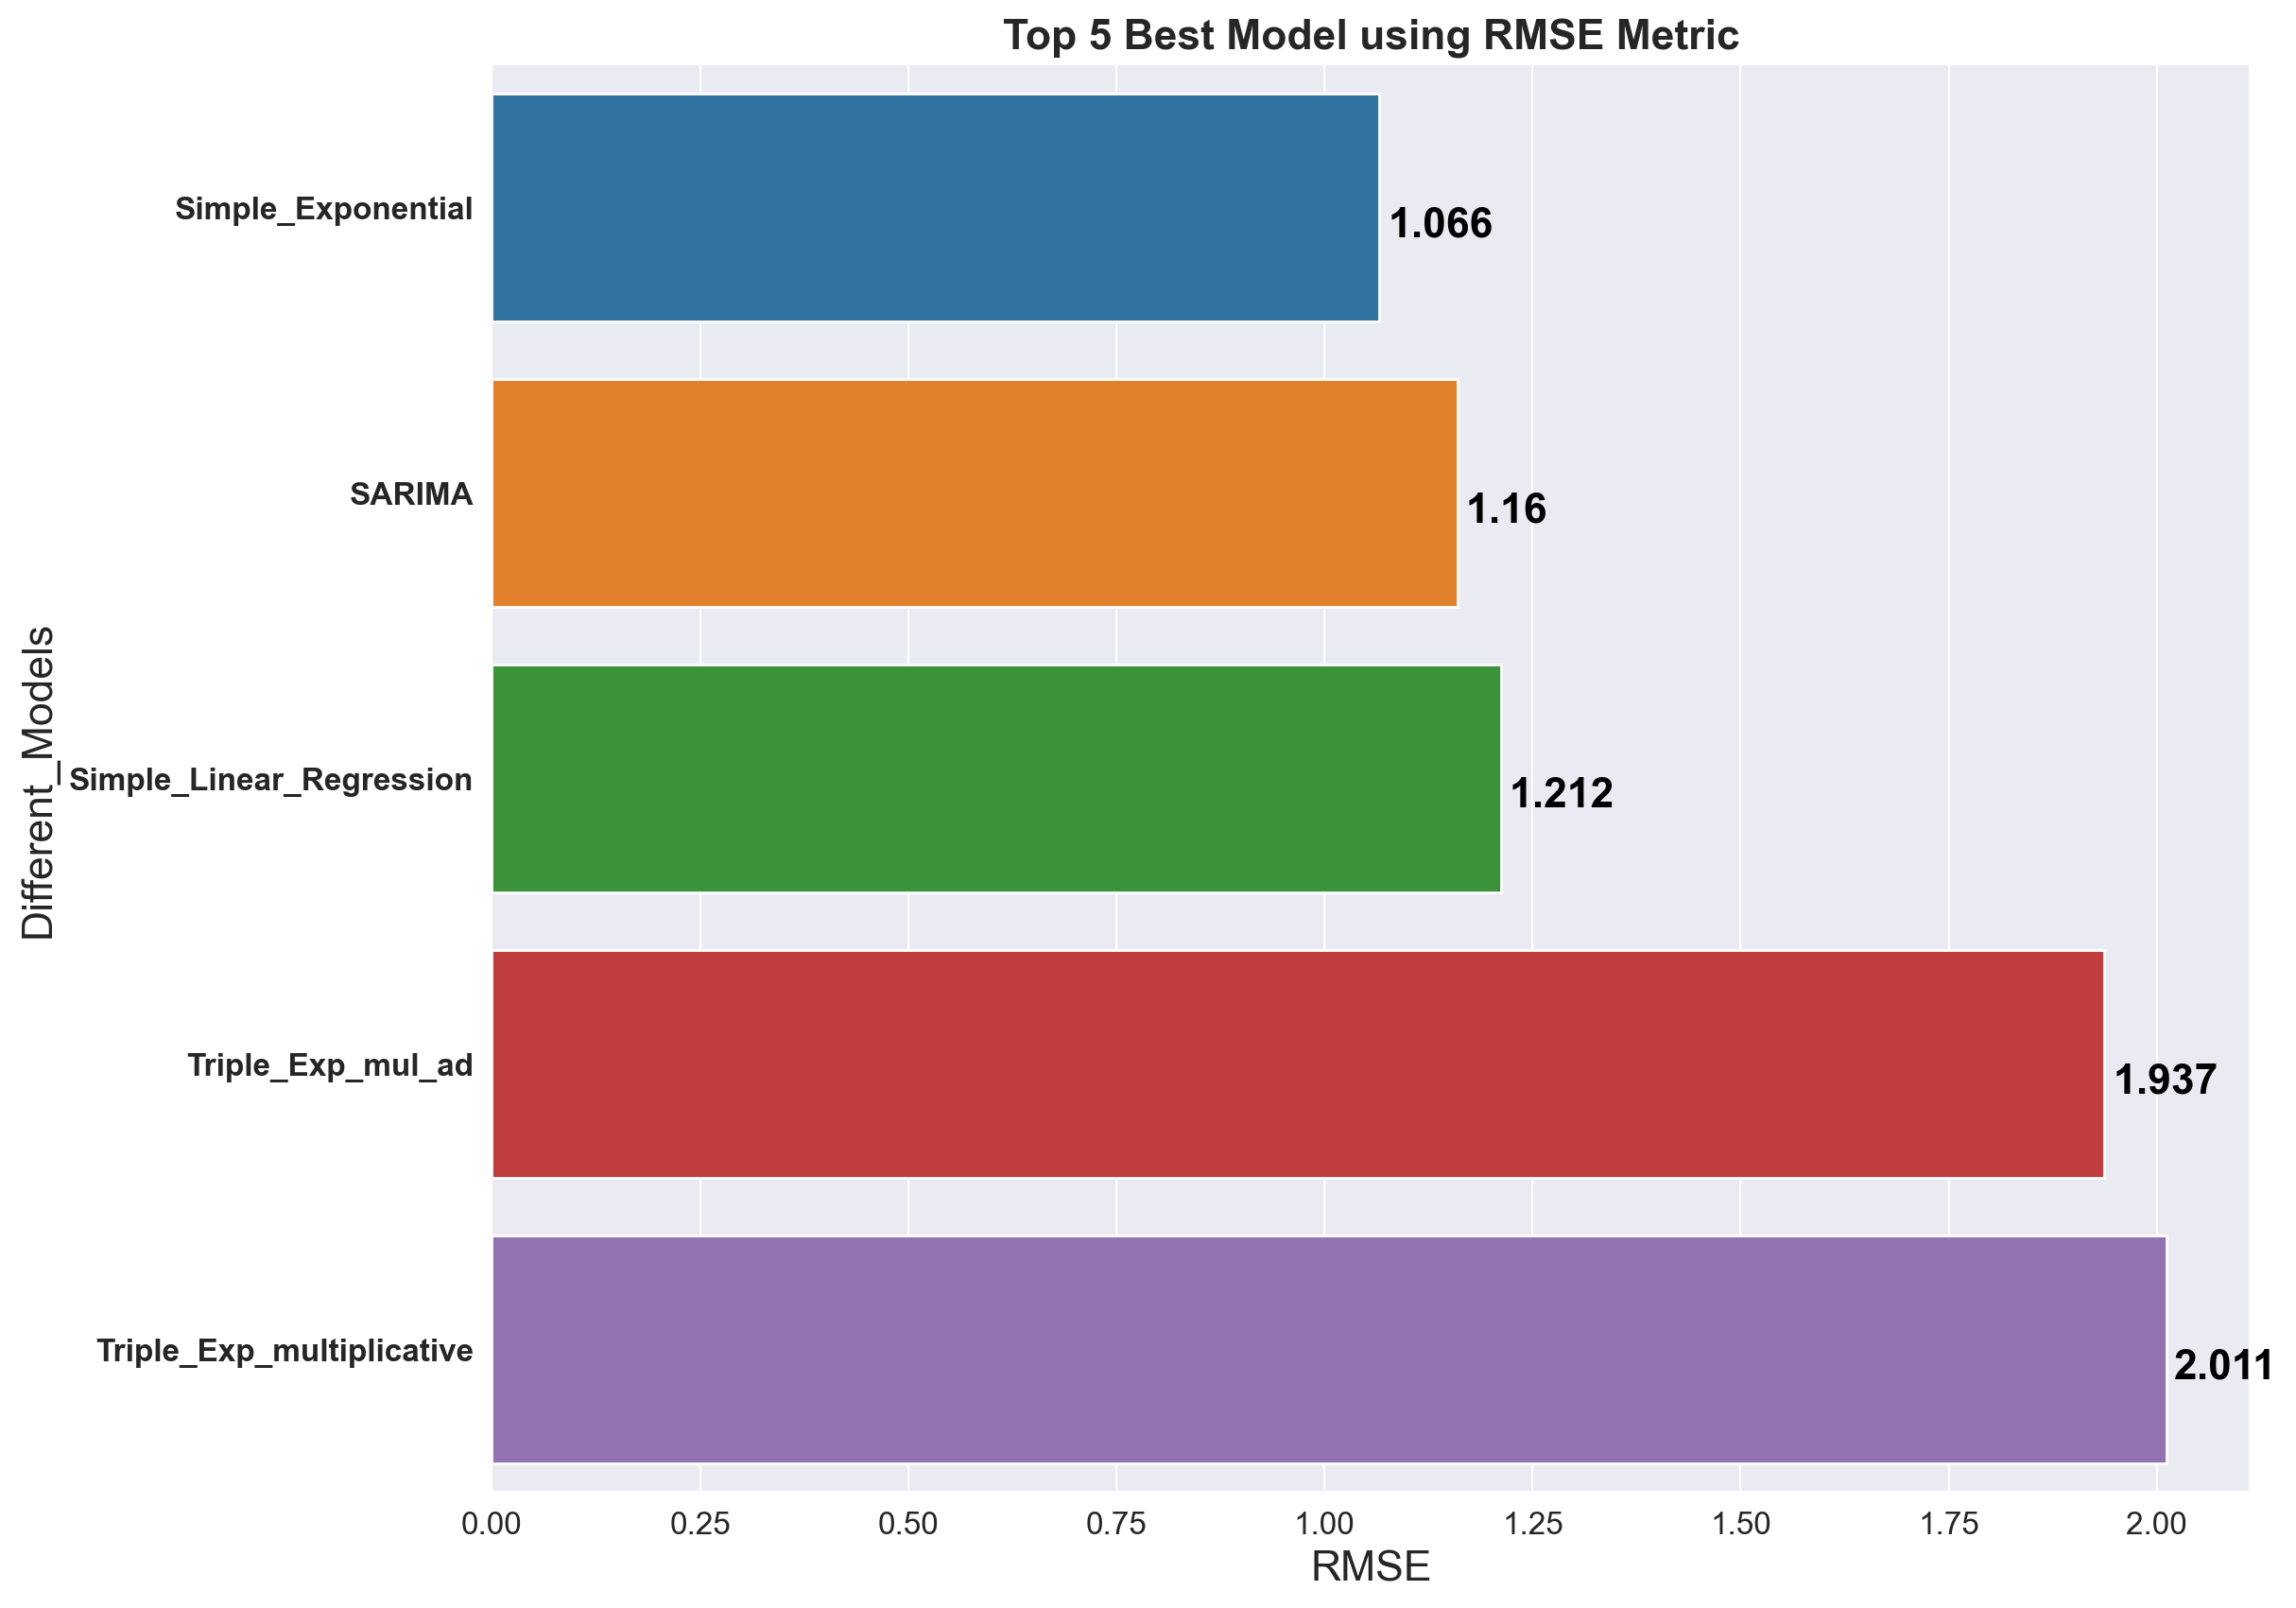

In [142]:
f, axe = plt.subplots(1,1, figsize=(12,10), dpi=200)
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=12)
plt.title('Top 5 Best Model using RMSE Metric', fontsize=16, fontweight='bold')

for i, v in enumerate(np.round(e.RMSE_Values.values,3)):
    axe.text(v + 0.01, i + .1, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

#### Conclusion:
## <p style="color:black;font-size:18;">Simple Exponential Method:</p><p style="color:black;font-size:14px;">The best model we have got so far with the lowest RMSE and lowest MAPE.</p>    

## Links for the repositories

<div style="display:fill;
            border-radius: false;
            border-style: solid;
            border-color:#000000;
            border-style: false;
            border-width: 2px;
            color:#CF673A;
            font-size:15px;
            font-family: Georgia;
            background-color:#E8DCCC;
            text-align:center;
            letter-spacing:0.1px;
            padding: 0.1em;">

**<h2>♡ Thank you for taking the time ♡**